In [1]:
import json

import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

import parser

In [2]:
# TODO: account for prev/next
import collections

class BoardStateNode:
    def __init__(self, idx, label):
        self.key = idx
        self.label = label
        
    def __repr__(self):
        return self.label
    
    def __hash__(self):
        return hash(self.key)
    
    
class ResetNode:
    def __init__(self, idx):
        self.key = idx
        self.label = "RESET"
        
    def __repr__(self):
        return self.label
    
    def __hash__(self):
        return hash(self.key)

# Thanks to Uniyal @ SO: 
# https://stackoverflow.com/a/1458716
class NodeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, BoardStateNode): return obj.__repr__()
        elif isinstance(obj, ResetNode): return obj.__repr__()
        return super(NodeEncoder, self).default(obj)


def get_state_graphs(level):
    """
    Get all the state graphs for a given playthough of a given level.
    """
    graphs = []
    for action in level.actions:
        if action["1"]["action_id"] == "victory":
            graphs[-1][1]["victory"] = True

        if action["1"]["action_id"] != "state-path-save":
            continue
            
        graph_detail = json.loads(action["1"]["action_detail"])
        graph_detail["victory"] = False
        graph_detail["reset"] = False
        graph = nx.DiGraph()
        nodes = []
        for idx, node in enumerate(graph_detail["nodes"]):
            if "data" in node and node["data"] == "reset":
                nodes.append(ResetNode(idx))
                graph_detail["reset"] = True
            else:
                nodes.append(BoardStateNode(idx, str(node["data"]["board"])))

        graph.add_nodes_from(nodes)
        
        for edge in graph_detail["edges"]:
            graph.add_edge(nodes[edge["from"]], nodes[edge["to"]])
        
        graphs.append((graph, graph_detail))
    return graphs


def get_complete_state_graphs(level_sequence, level_id):
    """Get all state graphs for all playthroughs of a given level."""
    graphs = []
    for level in level_sequence:
        if level.id == level_id:
            graphs.extend(get_state_graphs(level))
    return graphs

def only_complete_graphs(graphs):
    """
    Filter out graphs not caused by victory or reset. 
    """
    return [(graph, data) for (graph, data) in graphs if data["reset"] or data["victory"]]


def draw_graph(graph, size=(20, 20)):
    # Make the plot bigger
    plt.figure(3,figsize=size)
    nx.draw_networkx(
        graph[0], 
        with_labels=True,
        arrows=True,
        node_shape='s'
    )
    
def merge_graphs(graphs):
    nodes = []
    edges = []
    idx_mapping = {}  # (graph_idx, idx) -> node_idx
    node_mapping = {} # (sorted_board_state) -> node_idx
    
    for (graph_idx, (_, graph_detail)) in enumerate(graphs):
        for idx, node in enumerate(graph_detail["nodes"]):
            if node["data"] == "reset":
                if "reset" not in node_mapping:
                    nodes.append("reset")
                    idx_mapping[(graph_idx, idx)] = len(nodes) - 1
                    node_mapping["reset"] = len(nodes) - 1
                else:
                    idx_mapping[(graph_idx, idx)] = node_mapping["reset"]
            else:
                board_state = tuple(sorted(node["data"]["board"]))
                if board_state not in node_mapping:
                    nodes.append(board_state)
                    idx_mapping[(graph_idx, idx)] = len(nodes) - 1
                    node_mapping[board_state] = len(nodes) - 1
                else:
                    idx_mapping[(graph_idx, idx)] = node_mapping[board_state]
                    
        for edge in graph_detail["edges"]:
            edges.append((idx_mapping[(graph_idx, edge["from"])], 
                          idx_mapping[(graph_idx, edge["to"])]))
    
    graph = nx.DiGraph()
    node_instances = []
    for idx, node in enumerate(nodes):
        if node == "reset":
            node_obj = ResetNode(idx)
        else:
            node_obj = BoardStateNode(idx, str(node))
        node_instances.append(node_obj)
        graph.add_node(node_obj)
            
    for (start, end) in edges:
        graph.add_edge(node_instances[start], node_instances[end])
    
    return graph, {
        "nodes": nodes,
        "edges": edges,
    }

In [41]:
events, level_sequence = parser.read_events("../log_analyzer/nodejs-log-listener/userlogs/")

In [42]:
graphs = only_complete_graphs(get_state_graphs(level_sequence[75]))

### Vis.js graph visualization
Note: you *must* add vis.js to your static paths in your jupyter notebook config file. Please see [this tutorial](https://www.codementor.io/isaib.cicourel/visjs-visualization-in-jupyter-notebook-phgb3fjv0) for details.

*(Eventually we will wrap this module in a .js file and also add it to static paths, but for now the logic is not finished yet.)*

In [49]:
# Convert some graph data into a JSON string
from networkx.readwrite import json_graph
import json
graph_to_json = lambda G: json.dumps(json_graph.node_link_data(G), cls=NodeEncoder)
test_data = graph_to_json(graphs[0][0])

# Pass graph data to JS backend
from IPython.display import Javascript
Javascript("""
           window.graph_data={};
           """.format(test_data));

In [45]:
%%javascript

/* Converts the networkx output (serialized through JSON) 
*  to vis.js format. */
function nx_to_vis(G) {
    
    // Convert nodes from nx format into vis.js format:
    var nodes = G["nodes"].map(function(n, idx) {
        return { id: idx, label: n["id"] }
    });
    
    // Convert edges ('links') to vis.js format:
    var edges = G["links"].map(function(e) {
        return { from: e["source"], to: e["target"] }
    });
    
    return {
        nodes: nodes,
        edges: edges
    };
}

require.config({
    paths: {
        vis: 'vis'
    }
});

require(['vis'], function(vis){
    
    // (a weird idempotency thing)
    $("#net1").remove();
    
    // Create an element to put the network into
    element.append("<div id='net1' style='border:solid 1px'></div>");
    
    // Load the JSON graph we sent from Python.
    var graph_json = window.graph_data;
    
    // Decode it to vis.js format:
    var data = nx_to_vis(graph_json);

    // Create the network
    var container = document.getElementById('net1');
    var options = {
        width: '800px',
        height: '400px',
        nodes: {
            shape: 'box'
        }
    };
    var network = new vis.Network(container, data, options);
});

<IPython.core.display.Javascript object>

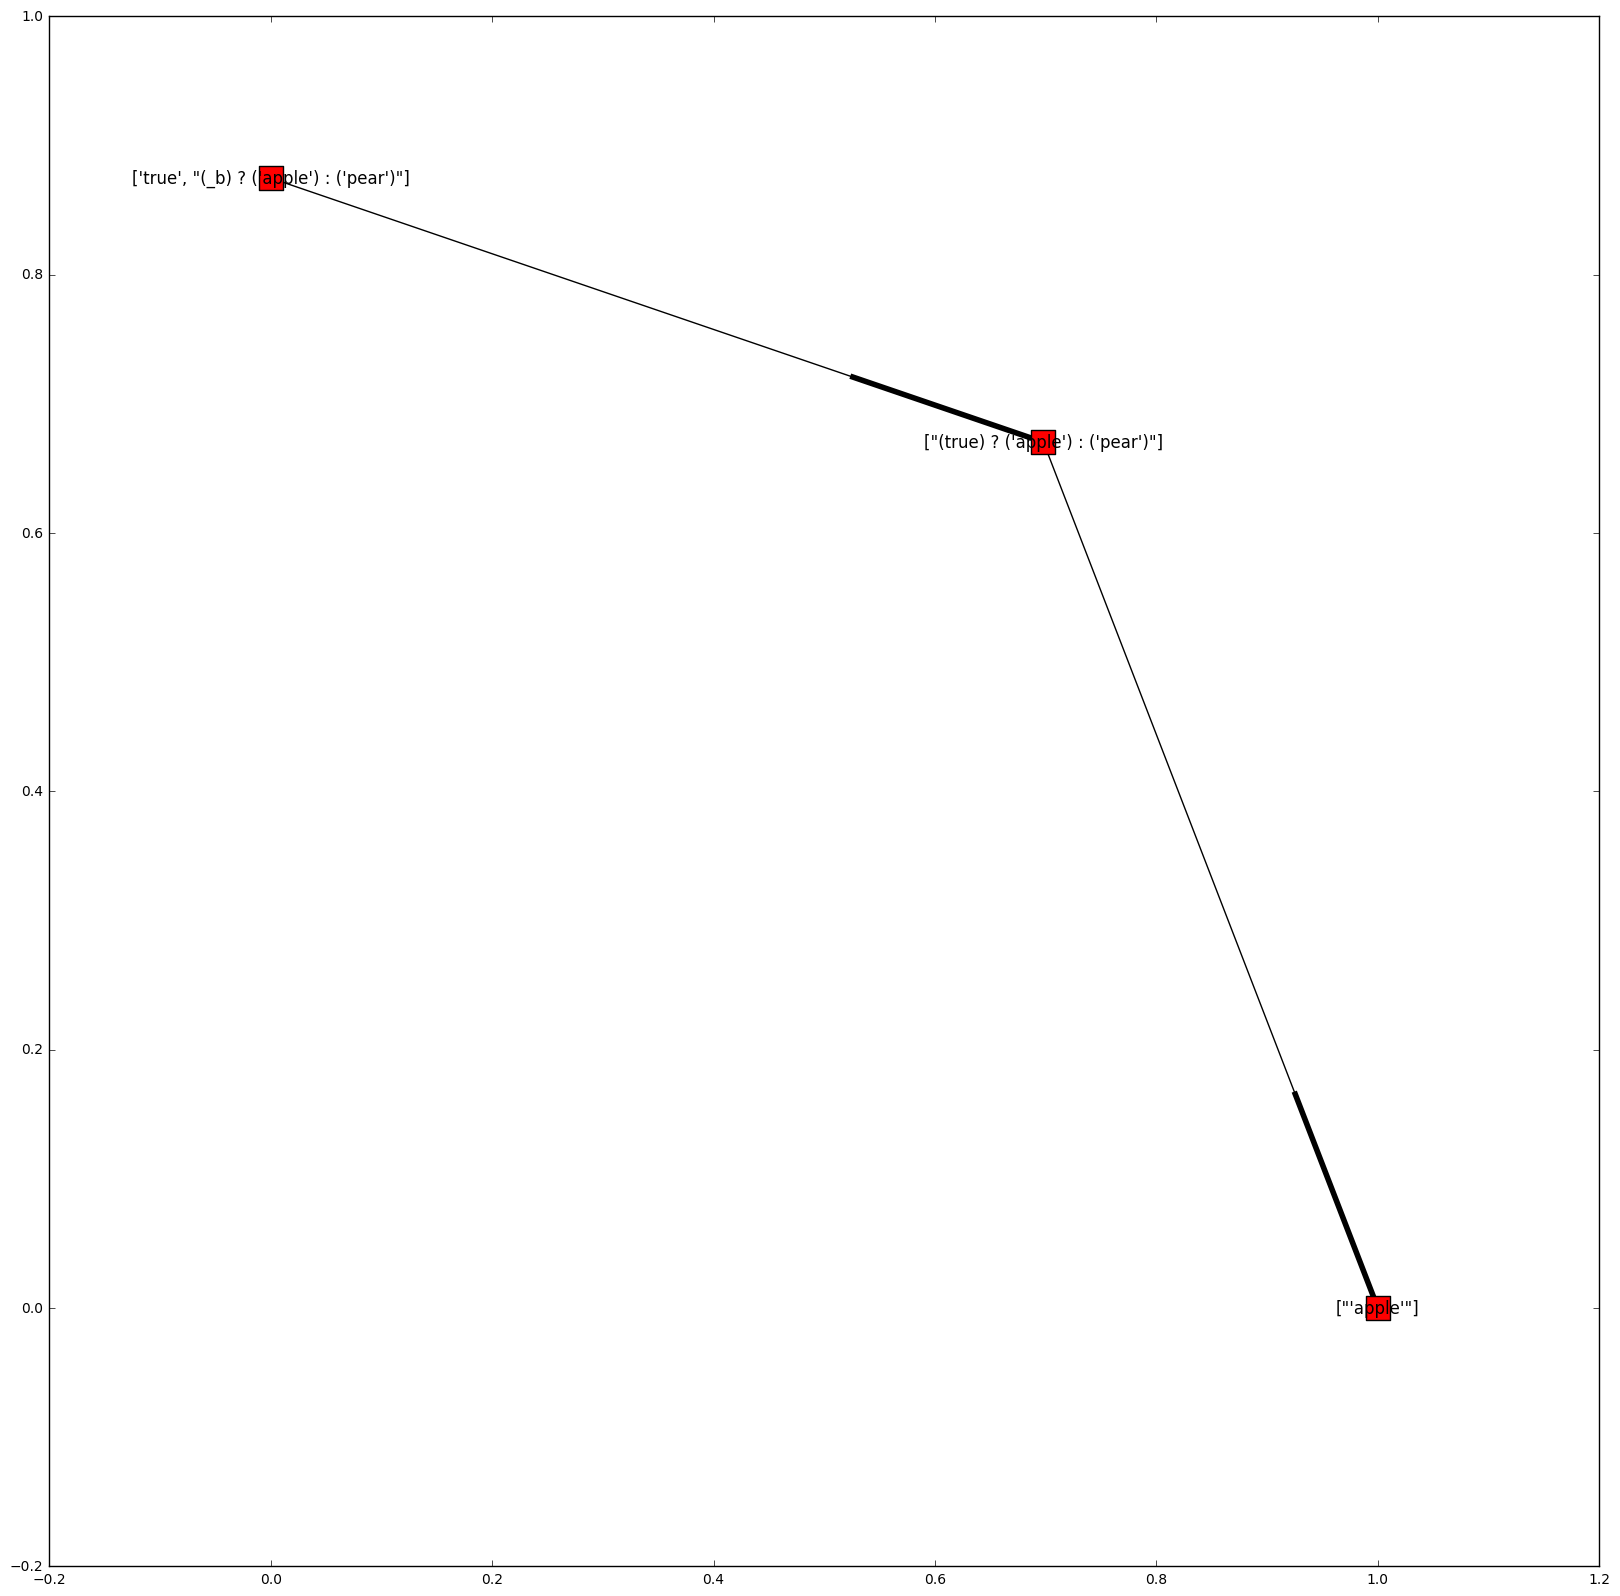

In [38]:
draw_graph(graphs[0])

In [23]:
x = [(i,l) for (i,l) in enumerate(level_sequence) if l.id == 65]
[(i[0], len(i[1].actions)) for i in x]

[(133, 158), (139, 3), (141, 84)]

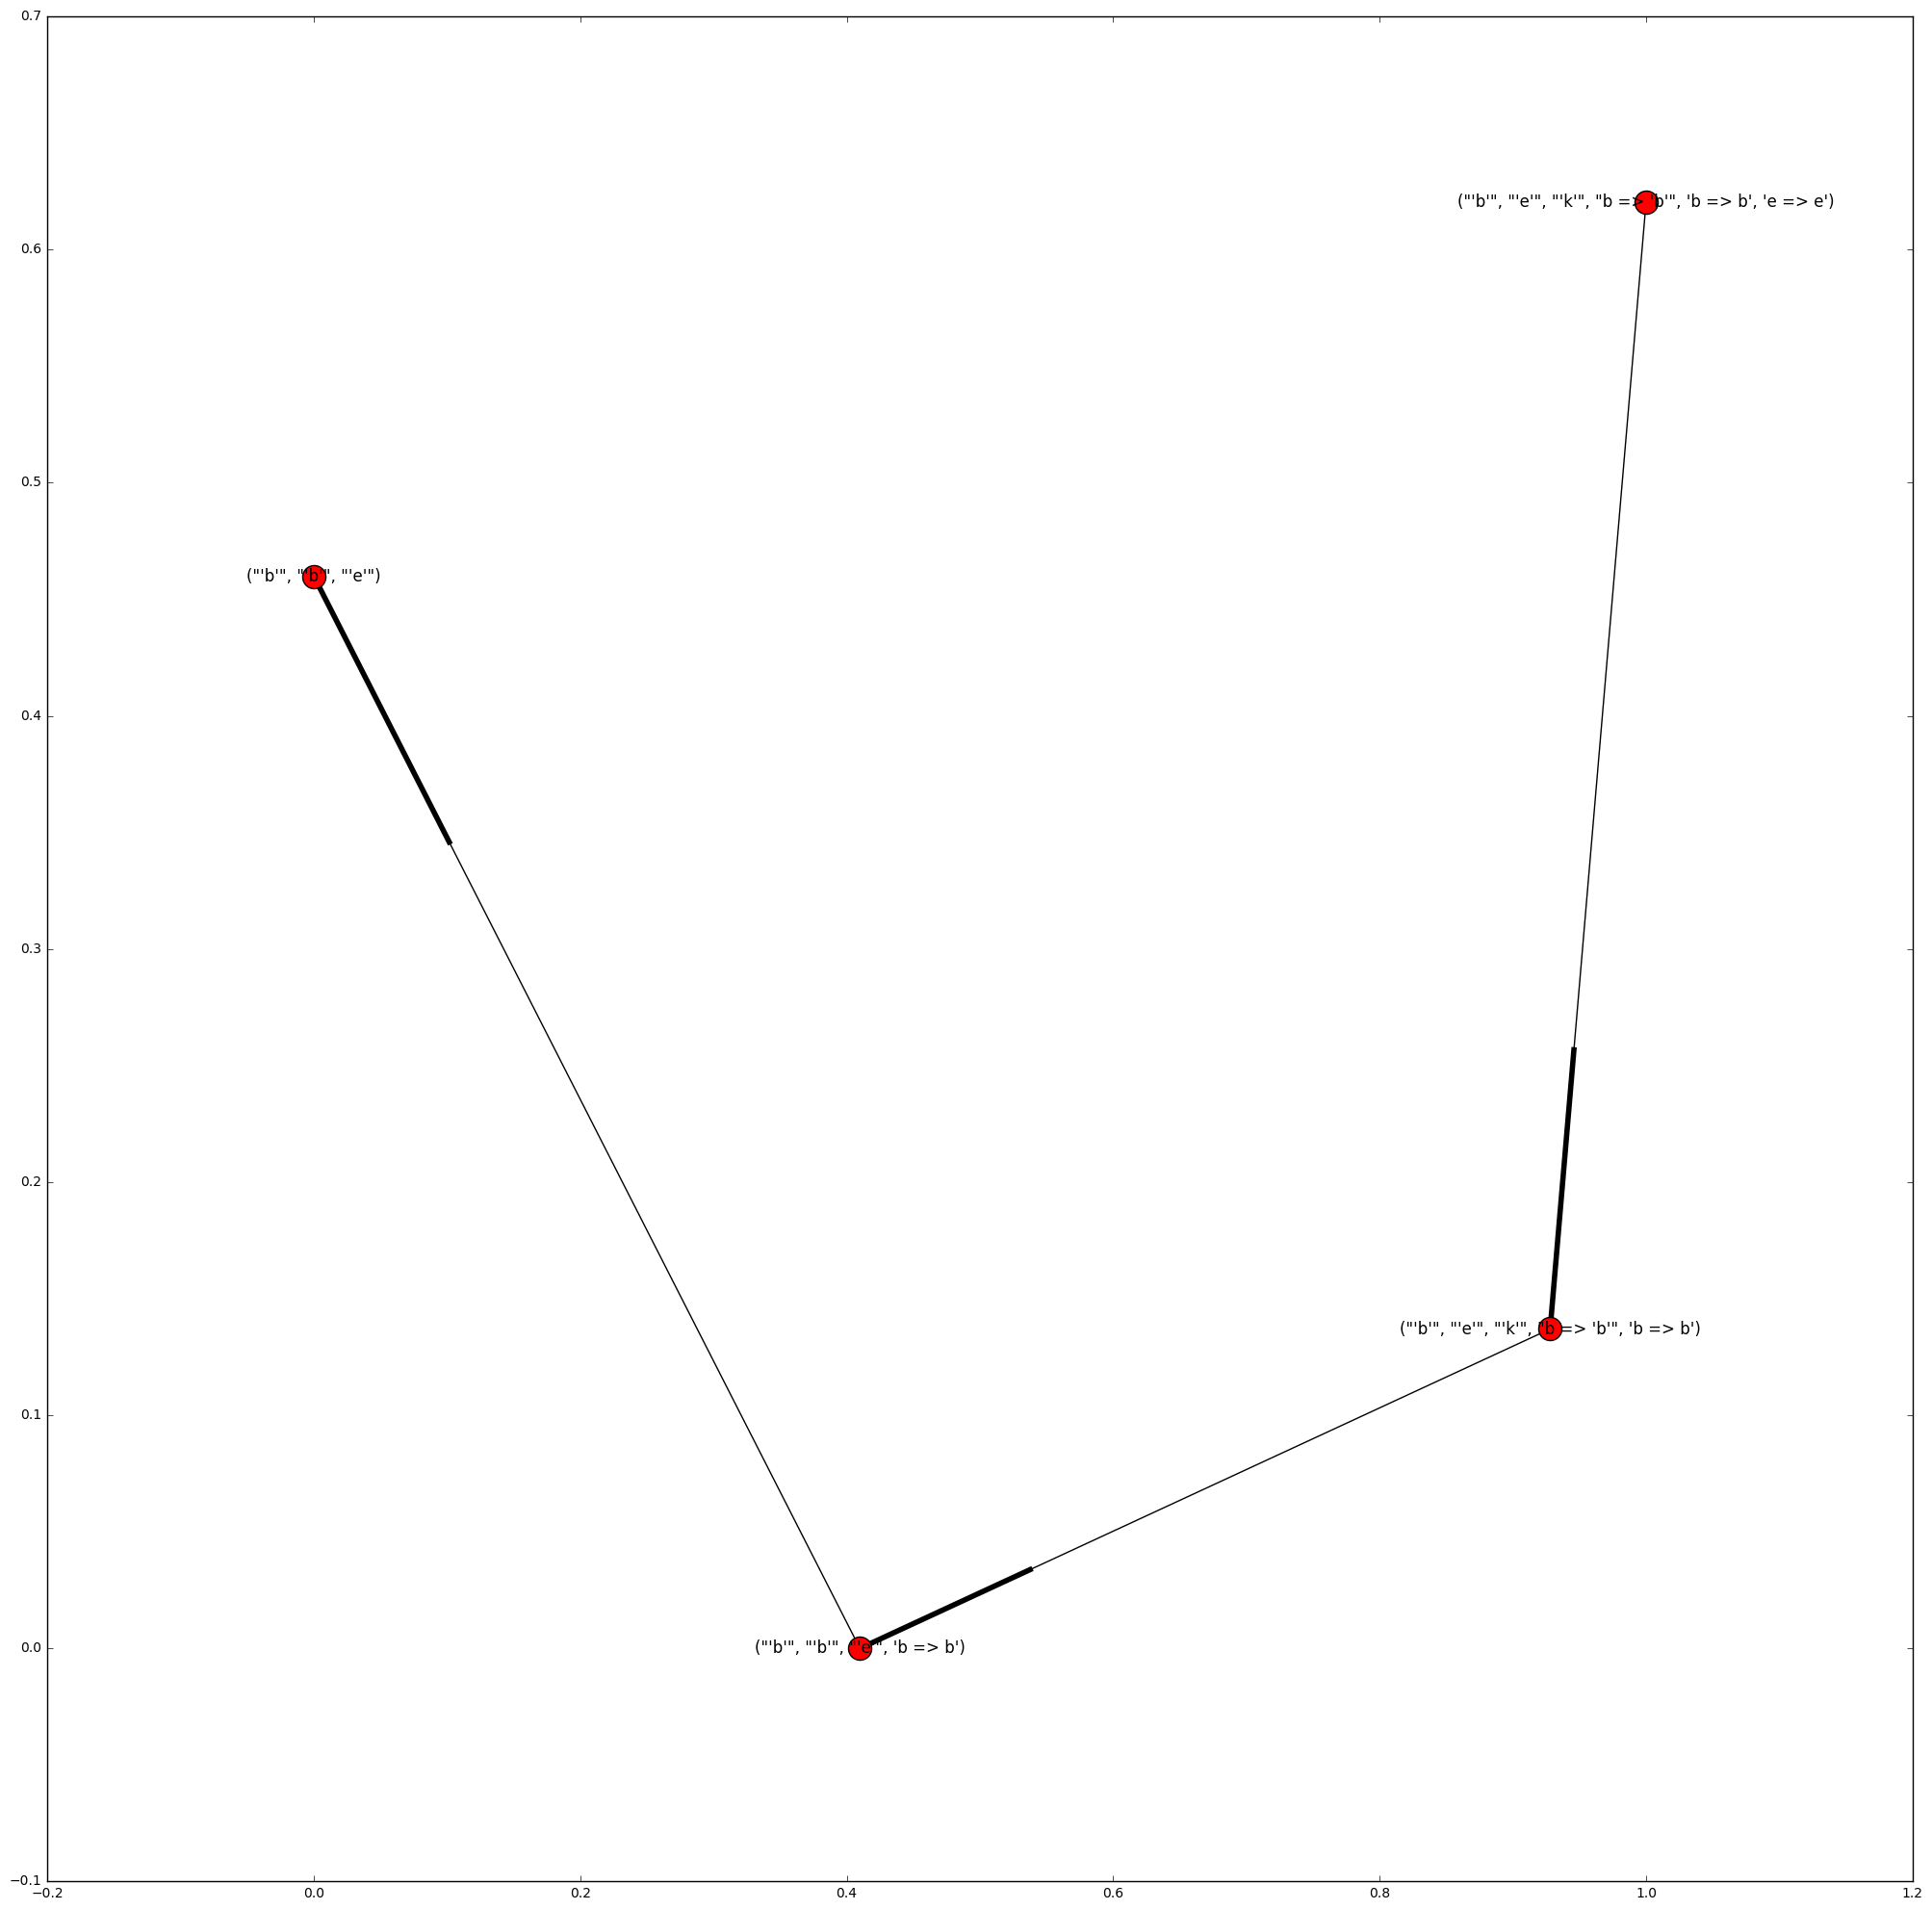

In [24]:
draw_graph(merge_graphs(only_complete_graphs(get_complete_state_graphs(level_sequence, 50))),
           size=(25, 25))